# Structure Segmentation

## Obtain Predictions

In [1]:
import json

import numpy as np
from torch import optim, nn

from diurnal import database, structure, train, transform, visualize, evaluate, segment
from diurnal.models import deep
from diurnal.models.deep import cnn

In [2]:
database.download("./data/", "archiveII")
SRC = "./data/archiveII/"  # Input directory containing the CT files.
SIZE = 128  # RNA molecule maximum length (longer ones are filtered out).
DST = f"./data/archiveII_processed_{SIZE}/"  # Output directory of the formatted files.
names = database.format_filenames(SRC, DST + "names.txt", SIZE)
train_names, validation_names, test_names = train.split(
    names, (0.8, 0.1, 0.1)
)

2024-06-08T10:08:51.957678 > INFO Download and install an RNA database.
2024-06-08T10:08:51.995183 >     The dataset `archiveII` is already downloaded at `./data/archiveII`.
2024-06-08T10:08:51.997372 > INFO Extract the filenames from the directory `./data/archiveII/`.


100%|██████████| 3975/3975 [00:00<00:00, 11457.96it/s]


2024-06-08T10:08:52.376106 >     Detected 3975 files. Kept 2326 files.
2024-06-08T10:08:52.380177 >     The file `./data/archiveII_processed_128/names.txt` already contains the names.


In [3]:
def format(dst: str, names: list[str]):
    # Primary structures
    pp_scalar = lambda x, y: structure.Primary.to_matrix(
        x, y, structure.Schemes.IUPAC_PAIRINGS_SCALARS
    )
    database.format_primary_structure(
        names, f"{dst}primary_potential_pairings_scalar.npy", SIZE, pp_scalar
    )
    database.format_primary_structure(
        names, f"{dst}primary_masks.npy", SIZE, structure.Primary.to_mask
    )
    database.format_primary_structure(
        names, f"{dst}primary_onehot.npy",
        SIZE, structure.Primary.to_onehot
    )
    # Secondary structures.
    database.format_secondary_structure(
        names, f"{dst}secondary_contact.npy", SIZE,
        structure.Secondary.to_matrix
    )
    database.format_secondary_structure(
        names, f"{dst}secondary_contact_expanded.npy", SIZE,
        segment.expansion_formatter
    )


def format_data(input, output) -> tuple:
    train_set = {
        "input": (np.load(f"{DST}train/{input}.npy"), ),
        "output": np.load(f"{DST}train/{output}.npy"),
        "names": []
    }
    validation_set = {
        "input": (np.load(f"{DST}validation/{input}.npy"), ),
        "output": np.load(f"{DST}validation/{output}.npy"),
        "names": []
    }
    test_set = {
        "input": (np.load(f"{DST}test/{input}.npy"), ),
        "output": np.load(f"{DST}test/{output}.npy"),
        "target": np.load(f"{DST}test/secondary_contact.npy"),
        "mask": np.load(f"{DST}test/primary_masks.npy"),
        "names": []
    }
    return train_set, validation_set, test_set

In [4]:
format(f"{DST}validation/", validation_names)
format(f"{DST}test/", test_names)
format(f"{DST}train/", train_names)

2024-06-08T10:08:52.407972 > INFO Formatting primary structures into `./data/archiveII_processed_128/validation/primary_potential_pairings_scalar.npy`.
2024-06-08T10:08:52.414841 >     The file `./data/archiveII_processed_128/validation/primary_potential_pairings_scalar.npy` already contains the formatted data.
2024-06-08T10:08:52.417193 > INFO Formatting primary structures into `./data/archiveII_processed_128/validation/primary_masks.npy`.
2024-06-08T10:08:52.452604 >     The file `./data/archiveII_processed_128/validation/primary_masks.npy` already contains the formatted data.
2024-06-08T10:08:52.456100 > INFO Formatting primary structures into `./data/archiveII_processed_128/validation/primary_onehot.npy`.
2024-06-08T10:08:52.458320 >     The file `./data/archiveII_processed_128/validation/primary_onehot.npy` already contains the formatted data.
2024-06-08T10:08:52.462747 > INFO Formatting secondary structures into `./data/archiveII_processed_128/validation/secondary_contact.npy`.
2

100%|██████████| 232/232 [01:00<00:00,  3.86it/s]


2024-06-08T10:09:52.911514 >     Encoded 232 files.
2024-06-08T10:09:52.963351 > INFO Formatting primary structures into `./data/archiveII_processed_128/test/primary_potential_pairings_scalar.npy`.
2024-06-08T10:09:52.994914 >     The file `./data/archiveII_processed_128/test/primary_potential_pairings_scalar.npy` already contains the formatted data.
2024-06-08T10:09:52.997693 > INFO Formatting primary structures into `./data/archiveII_processed_128/test/primary_masks.npy`.
2024-06-08T10:09:53.047958 >     The file `./data/archiveII_processed_128/test/primary_masks.npy` already contains the formatted data.
2024-06-08T10:09:53.053967 > INFO Formatting primary structures into `./data/archiveII_processed_128/test/primary_onehot.npy`.
2024-06-08T10:09:53.077464 >     The file `./data/archiveII_processed_128/test/primary_onehot.npy` already contains the formatted data.
2024-06-08T10:09:53.082350 > INFO Formatting secondary structures into `./data/archiveII_processed_128/test/secondary_conta

100%|██████████| 232/232 [01:03<00:00,  3.67it/s]


2024-06-08T10:10:56.629119 >     Encoded 232 files.
2024-06-08T10:10:56.704155 > INFO Formatting primary structures into `./data/archiveII_processed_128/train/primary_potential_pairings_scalar.npy`.
2024-06-08T10:10:56.758808 >     The file `./data/archiveII_processed_128/train/primary_potential_pairings_scalar.npy` already contains the formatted data.
2024-06-08T10:10:56.762373 > INFO Formatting primary structures into `./data/archiveII_processed_128/train/primary_masks.npy`.
2024-06-08T10:10:56.841491 >     The file `./data/archiveII_processed_128/train/primary_masks.npy` already contains the formatted data.
2024-06-08T10:10:56.844718 > INFO Formatting primary structures into `./data/archiveII_processed_128/train/primary_onehot.npy`.
2024-06-08T10:10:56.866283 >     The file `./data/archiveII_processed_128/train/primary_onehot.npy` already contains the formatted data.
2024-06-08T10:10:56.868296 > INFO Formatting secondary structures into `./data/archiveII_processed_128/train/secondar

100%|██████████| 1860/1860 [07:54<00:00,  3.92it/s]


2024-06-08T10:18:51.259205 >     Encoded 1860 files.


In [5]:
t, v, tt = format_data(
    "primary_potential_pairings_scalar",
    "secondary_contact"
)
N_MAX_EPOCHS = 500
model = deep.NN(
    model=cnn.UNet2D(SIZE, 4),
    n_epochs=N_MAX_EPOCHS,
    optimizer=optim.Adam,
    loss_fn=nn.CrossEntropyLoss,
    optimizer_args={"eps": 1e-4},
    loss_fn_args=None,
    use_half=False,
    patience=5,
    verbosity=2,
)
model.train(t, v)

2024-06-08T10:18:56.215264 > INFO Training the model with 1860 data points.
2024-06-08T10:18:56.216282 >     Using 232 data points for validation.
2024-06-08T10:18:56.218781 >     Beginning the training.
2024-06-08T10:19:05.257840 >   0 / 500 [                                                  ] Loss: 2.14972  Patience: 5
2024-06-08T10:19:06.137033 >   1 / 500 [                                                  ] Loss: 2.09909  Patience: 5
2024-06-08T10:19:07.016610 >   2 / 500 [                                                  ] Loss: 2.08186  Patience: 5
2024-06-08T10:19:07.984128 >   3 / 500 [                                                  ] Loss: 2.07401  Patience: 5
2024-06-08T10:19:08.864053 >   4 / 500 [                                                  ] Loss: 2.06874  Patience: 5
2024-06-08T10:19:09.728155 >   5 / 500 [                                                  ] Loss: 2.06534  Patience: 5
2024-06-08T10:19:10.601006 >   6 / 500 [                                          

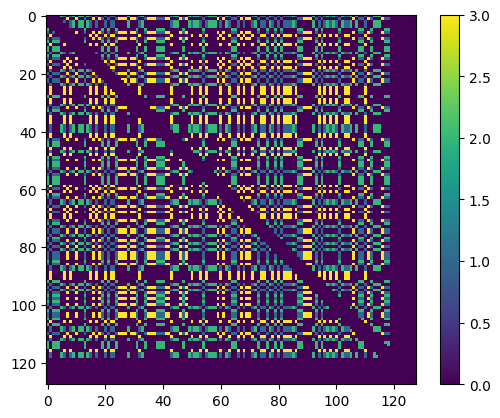

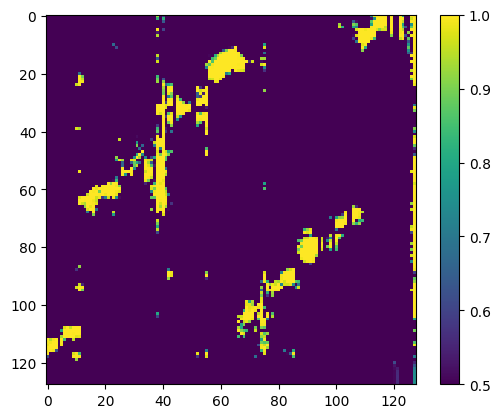

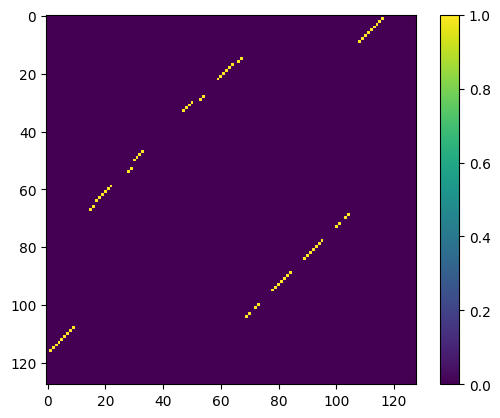

In [6]:
index = 1
visualize.heatmap(tt["input"][0][index])
p = model.predict([tt["input"][0][index]])
visualize.heatmap(p)
visualize.heatmap(tt["output"][index])

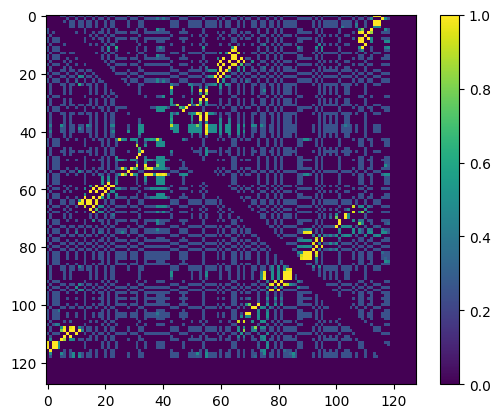

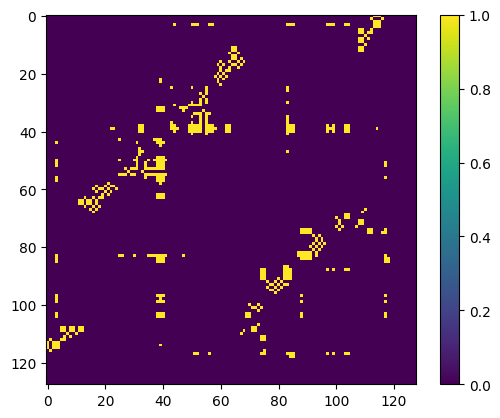

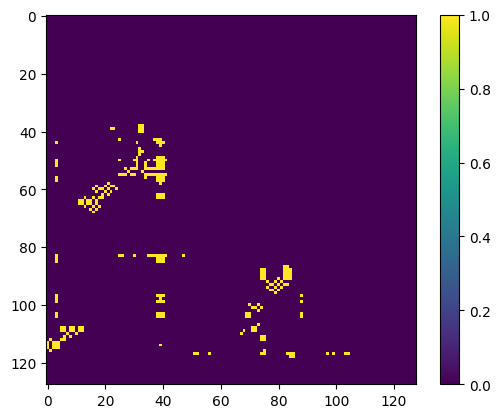

In [7]:
p_mask = p * tt["mask"][1]
p2 = p_mask * p_mask.T
visualize.heatmap(p2)
p3 = segment.convolutional_denoise(p2)
visualize.heatmap(p3)

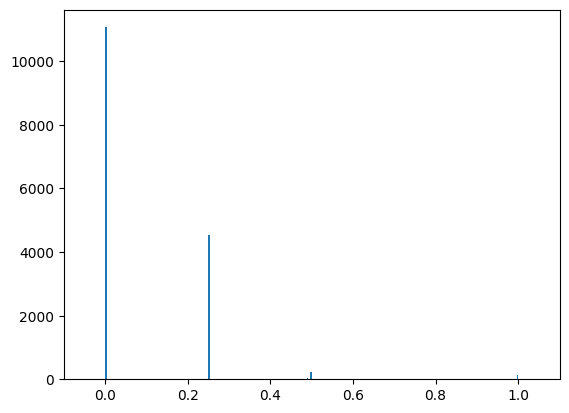

In [17]:
import matplotlib.pyplot as plt

b, bins, patches = plt.hist(p2.flatten(), 256)
plt.xlim([-0.1, 1.1])
plt.show()

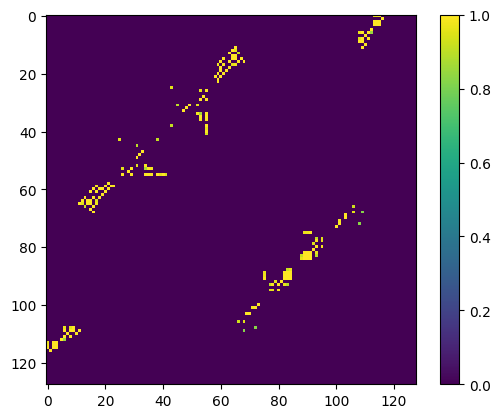

In [22]:
p4 = (p2 > 0.5) * p2
visualize.heatmap(p4)

False
[[47. 46. 45. ...  9. 10. 11.]
 [46. 46. 45. ...  9. 10. 11.]
 [45. 45. 45. ...  9. 10. 11.]
 ...
 [ 9.  9.  9. ... 41. 41. 41.]
 [10. 10. 10. ... 41. 42. 42.]
 [11. 11. 11. ... 41. 42. 43.]]


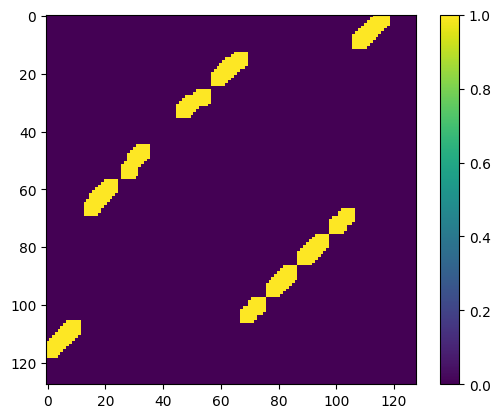

In [ ]:
s2 = segment.expand_regions(tt["output"][index])
visualize.heatmap(s2)

In [26]:
from os import mkdir

try:
    mkdir("tmp")
except:
    pass

from tqdm import tqdm

predictions = []
for i in tqdm(range(len(t["input"][0]))):
    p = model.predict([t["input"][0][i]])
    predictions.append(p)
np.save("tmp/train_predictions.npy", np.array(predictions))

predictions = []
for i in tqdm(range(len(v["input"][0]))):
    p = model.predict([v["input"][0][i]])
    predictions.append(p)
np.save("tmp/validation_predictions.npy", np.array(predictions))

predictions = []
for i in tqdm(range(len(tt["input"][0]))):
    p = model.predict([tt["input"][0][i]])
    predictions.append(p)
np.save("tmp/test_predictions.npy", np.array(predictions))

100%|██████████| 232/232 [00:00<00:00, 434.13it/s]
